In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from math import pi
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set_theme(style="white", context="talk")

import iqplot
import bokeh.io
from bokeh.layouts import column, gridplot
from bokeh.models import ColorBar, ColorMapper, LinearColorMapper, Ticker
bokeh.io.output_notebook()

import sgd_utils as sgd
import random

Loading BokehJS ...

Loading BokehJS ...

In [2]:
%load_ext blackcellmagic

In [3]:
def get_top_pop_movie_data(data, movies, topn):
    """Get the top rated movie ratings"""
    data_lists = []
    movie_count = get_pop_movie(data, movies)
    for i in movie_count.MOVIE_ID[:topn]:
        data_lists.append(data[data.MOVIE == i])
    return merge_title(pd.concat(data_lists), movies)


def get_pop_movie(data, movies):
    """Get the number and title of rated movies"""
    movie_count = pd.DataFrame(data.MOVIE.value_counts()).reset_index()
    movie_count.columns = ["MOVIE_ID", "RATING_COUNTS"]
    return movie_count


def merge_title(df, movies, ifgenres=False):
    """Add movie titles"""
    if "MOVIE" in df.columns:
        df = df.rename(columns={"MOVIE": "MOVIE_ID"})
    if not ifgenres:
        movie_comb = movies.iloc[:, :2]
    else:
        movie_comb = movies

    df = df.merge(movie_comb, left_on="MOVIE_ID", right_on="MOVIE_ID", how="left")

    df.loc[df.TITLE.isnull(), "TITLE"] = (
        "MOVIE_ID: " + df.loc[df.TITLE.isnull(), "MOVIE_ID"]
    )

    return df

In [4]:
def load_data(f_data, f_train, f_test, f_movies):
    """Load the user and movie data, FZL modified"""

    data = load_train_test(f_data)
    train = load_train_test(f_train)
    test = load_train_test(f_test)

    movies = pd.read_csv(
        "https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/"
        + f_movies,
        encoding="latin-1",
        sep="\t",
        header=None,
        names=[
            "MOVIE_ID",
            "TITLE",
            "UNKNOWN",
            "ACTION",
            "ADVENTURE",
            "ANIMATION",
            "CHILDREN",
            "COMEDY",
            "CRIME",
            "DOCUMENTARY",
            "DRAMA",
            "FANTASY",
            "FILM-NOIR",
            "HORROR",
            "MUSICAL",
            "MYSTERY",
            "ROMANCE",
            "SCI-FI",
            "THRILLER",
            "WAR",
            "WESTERN",
        ],
    )

    movies.loc[movies.TITLE == "unknown", "TITLE"] = "MOVIE_ID: " + movies.loc[
        movies.TITLE == "unknown", "MOVIE_ID"
    ].astype("str")

    return data, train, test, movies

In [5]:
def load_train_test(trainortest):
    """Load train or test data"""
    return pd.read_csv(
        "https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/"
        + trainortest,
        sep="\t",
        header=None,
        names=["USER", "MOVIE", "RATING"],
    )

def check_dup(df, df_details):
    """Check fi there are duplicated entries for each dataframe"""
    print(f"There are {sum((df.duplicated())*1)} duplicate entires in {df_details}")

In [6]:
data, Y_train_df, Y_test_df, movies = load_data(
    "data.txt", "train.txt", "test.txt", "movies.txt"
)

check_dup(Y_train_df, "Y_train_df")
check_dup(Y_test_df, "Y_test_df")

There are 0 duplicate entires in Y_train_df
There are 0 duplicate entires in Y_test_df
There are 0 duplicate entires in Y_train_df
There are 0 duplicate entires in Y_test_df


## Matrix Factorization visualizations
### Method 1: HW5 solution

In [7]:
def get_MNY(Y_train_df, Y_test_df):
    """Return Y_train, Y_test, M, N, 
    where M is unique user IDs and N is unique movie IDs"""
    return (
        Y_train_df.to_numpy(),
        Y_test_df.to_numpy(),
        int(max(max(Y_train_df.USER), max(Y_test_df.USER))),
        int(max(max(Y_train_df.MOVIE), max(Y_test_df.MOVIE))),
    )

In [8]:
Y_train, Y_test, M, N = get_MNY(Y_train_df, Y_test_df)

print("Factorizing with ", M, " users, ", N, " movies.")
Ks = 20

reg = 0.0
eta = 0.03  # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
U, V, err_training = sgd.train_model(M, N, Ks, eta, reg, Y_train)
print("Err training", err_training)
print("Err testing", sgd.get_err(U, V, Y_test))
print("dim U [m x k]", U.shape)
print("dim V [k x n]", V.shape)

Factorizing with  943  users,  1682  movies.
Factorizing with  943  users,  1682  movies.
Epoch 1, E_in (regularized MSE): 0.5207409521962593
Epoch 1, E_in (regularized MSE): 0.5207409521962593
Epoch 2, E_in (regularized MSE): 0.397324175115462
Epoch 2, E_in (regularized MSE): 0.397324175115462
Epoch 3, E_in (regularized MSE): 0.3549338274589559
Epoch 3, E_in (regularized MSE): 0.3549338274589559
Epoch 4, E_in (regularized MSE): 0.3247931855696651
Epoch 4, E_in (regularized MSE): 0.3247931855696651
Epoch 5, E_in (regularized MSE): 0.310530577307572
Epoch 5, E_in (regularized MSE): 0.310530577307572
Epoch 6, E_in (regularized MSE): 0.2985793070586949
Epoch 6, E_in (regularized MSE): 0.2985793070586949
Epoch 7, E_in (regularized MSE): 0.282540621193733
Epoch 7, E_in (regularized MSE): 0.282540621193733
Epoch 8, E_in (regularized MSE): 0.2756218677561639
Epoch 8, E_in (regularized MSE): 0.2756218677561639
Epoch 9, E_in (regularized MSE): 0.2666201094313112
Epoch 9, E_in (regularized MSE):

In [9]:
## SVD

A, sigma, B = np.linalg.svd(V, full_matrices=False)
A_two_cols = A[:, 0:2]

U_proj = A_two_cols.transpose() @ U.transpose()
V_proj = A_two_cols.transpose() @ V

In [10]:
def visualize(V_proj, movie_titles, movie_genre):
    """ Plots V_proj with annotations from the lists of ids, genre and titles"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.axhline(y=0, color="r", linewidth=0.5)
    ax.axvline(x=0, color="r", linewidth=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    m_proj0 = np.mean(V_proj[0, :])
    m_proj1 = np.mean(V_proj[1, :])
    ax.plot(V_proj[0, :] - m_proj0, V_proj[1, :] - m_proj1, "o")
    ax.set_xlabel("V proj 0")
    ax.set_ylabel("V proj 1")

    offset = 0.01
    for i in range(len(list_movies_titles)):
        text = str(list_movies_titles[i]) + " | " + str(list_movies_genre[i])
        ax.annotate(
            text,
            (V_proj[0][i] - m_proj0 + offset, V_proj[1][i] - m_proj1 + offset),
            fontsize=8,
        )

    plt.show()


def get_list_movies_from_list_of_ids(data, list_movies_id):
    """ selects the movies with certain ids returns 3 lists of ids, genre and titles"""

    list_movies_genre = []
    list_movies_titles = []
    for idx in list_movies_id:
        movie_id_df = movies[movies["MOVIE_ID"] == idx]
        list_cols = []
        for i, v in enumerate(movie_id_df.values[0, :]):
            if v == 1:
                list_cols.append(movie_id_df.columns[i])
        list_movies_genre.append(list_cols)
        list_movies_titles.append(movie_id_df.values[0, 1])

    return list_movies_id, list_movies_genre, list_movies_titles

#### Visualize first 10 most popular movies

Top most popular movies [288, 1, 258, 100, 294, 300, 50, 181, 121, 286]
Top most popular movies [288, 1, 258, 100, 294, 300, 50, 181, 121, 286]


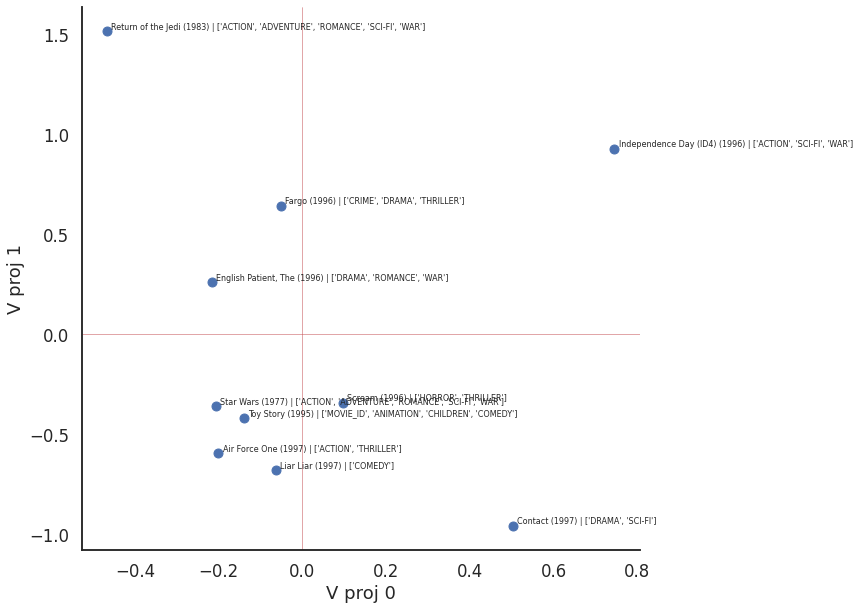

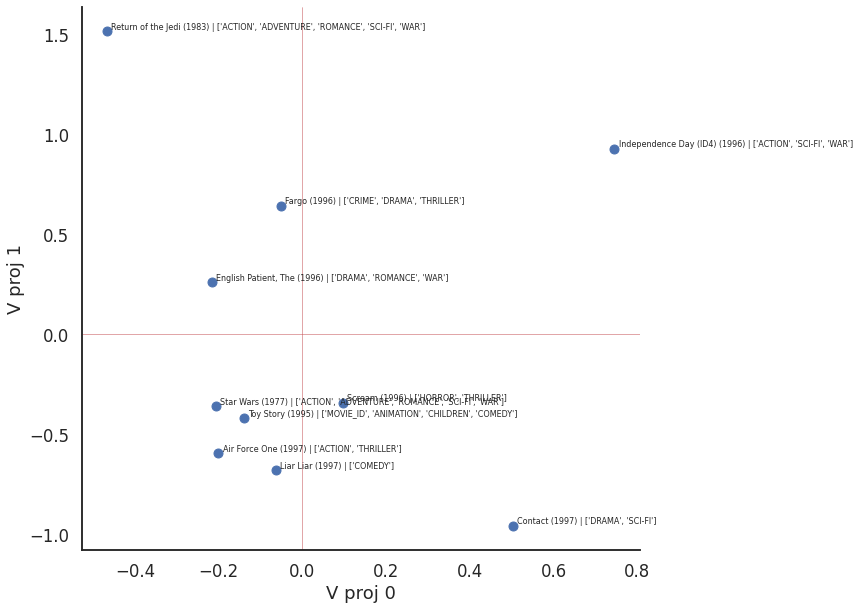

In [11]:
topn = 10
topn_pop_df = get_top_pop_movie_data(data, movies, topn)
list_movies_id = topn_pop_df.MOVIE_ID
list_movies_id = list(set(list_movies_id.to_list()))
print('Top most popular movies', list_movies_id)

list_movies_id, list_movies_genre, list_movies_titles = get_list_movies_from_list_of_ids(data, list_movies_id)

def get_V_proj_selection(list_movies_id, V_proj):
    V_proj_selection = np.zeros((2, len(list_movies_id)))
    for i, l in enumerate(list_movies_id):
        V_proj_selection[:,i] = V_proj[:, l]
        
    return V_proj_selection
   
V_proj_selection = get_V_proj_selection(list_movies_id, V_proj)
visualize(V_proj_selection, list_movies_titles, list_movies_genre)

### Method 2: Incorporate a and b for each user and move to model global tendencies of the various moves and users TODO

### Method 3: off-the-shelf implementation 

In [12]:
from surprise import SVD, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn

In [13]:
reader = Reader(rating_scale=(0,5))
train_dataset = Dataset.load_from_df(Y_train_df, reader)

train_dataset_object = train_dataset.build_full_trainset()

algo = SVD()
cross_validate(algo, train_dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

algo.fit(train_dataset_object)

print('pu shape', algo.pu.shape)
print('qi shape', algo.qi.shape)



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9408  0.9488  0.9403  0.9396  0.9406  0.9420  0.0034  
MAE (testset)     0.7411  0.7511  0.7413  0.7400  0.7408  0.7429  0.0042  
Fit time          2.44    2.46    2.44    2.44    2.44    2.45    0.01    
Test time         0.07    0.07    0.12    0.07    0.07    0.08    0.02    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9408  0.9488  0.9403  0.9396  0.9406  0.9420  0.0034  
MAE (testset)     0.7411  0.7511  0.7413  0.7400  0.7408  0.7429  0.0042  
Fit time          2.44    2.46    2.44    2.44    2.44    2.45    0.01    
Test time         0.07    0.07    0.12    0.07    0.07    0.08    0.02    
pu shape (943, 100)
qi shape (1668, 100)
pu shape (943, 100)
qi shape (1668, 100)


In [14]:
# sample of prediction
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(302)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)



user: 196        item: 302        r_ui = 4.00   est = 3.53   {'was_impossible': False}
user: 196        item: 302        r_ui = 4.00   est = 3.53   {'was_impossible': False}


#### Visualization

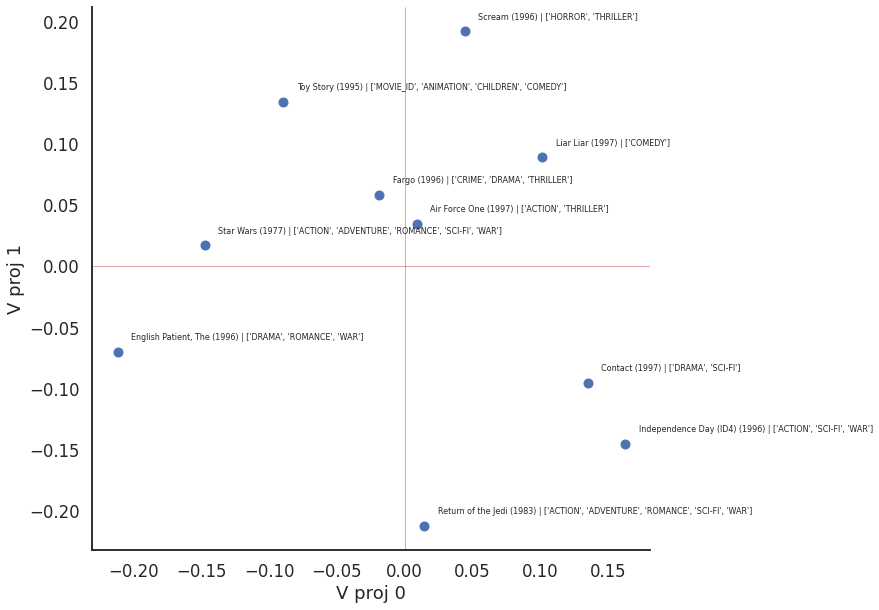

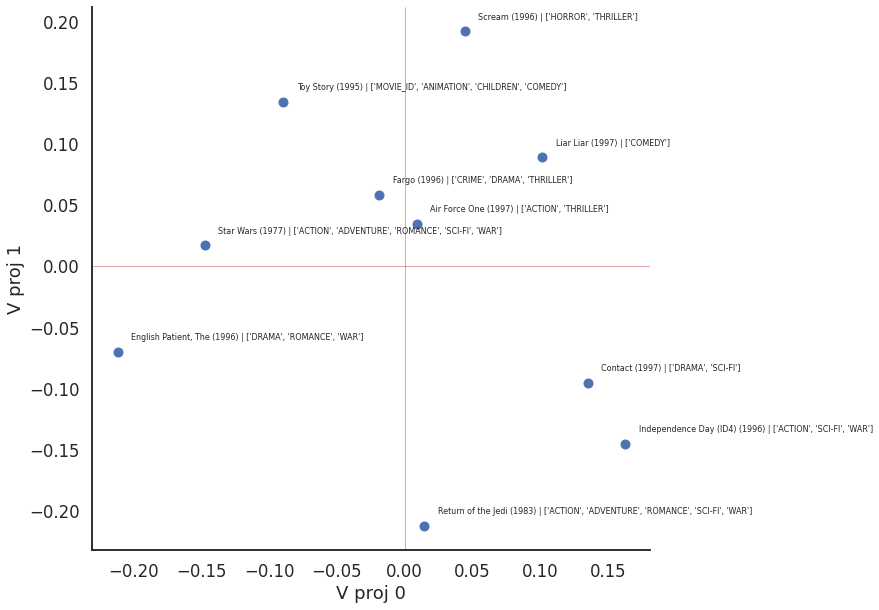

In [15]:
# same list as before
V_proj_selection = get_V_proj_selection(list_movies_id, V_proj)
visualize(algo.qi[:,0:10], list_movies_titles, list_movies_genre)

# print('pu',algo.pu)
# print('qi',algo.qi)